# Foundations of Logistic Regression

In [ ]:
import os

# Change the current working directory
# os.chdir('/Users/robertocerina/Desktop/CSSci Semester IV/')

In [ ]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

## Exercise I: Inference and Prediction for the Homogeneous-Probability Bernoulli Model

#### a) Simulate a sample of n = 100 Bernoulli distributed outcomes, with the following probability parameter:

In [50]:
p_value = np.random.uniform(low=0.0, high=1.0) # generate a random p-value between 0 and 1

print(p_value)

0.4439647384275476


#### do not look at the value of this parameters - we are going to pretend you're generating a fresh sample, and your goal is to estimate $\pi$. Imagine this $\pi$ represents the probability of any one of you saying they will vote for a right-of-centre party in the next Dutch election, and $n = 100$ suggests there are 100 of you to whom this question is being asked.

In [51]:
n = 100

# generate a sample of size n from a binomial distribution with number of trials = 1 and p = p_value
sample1 = np.random.binomial(n=1, p=p_value, size=n)
print(sample1)

# or directly use bernoulli.rvs from scipy.stats

sample2 = bernoulli.rvs(p=p_value, size=n)

print(sample2)

[1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0
 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1
 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1]
[1 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1
 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1
 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1]


#### b) Plot the empirical distribution (histogram of simulations) for this set of Bernoulli outcomes

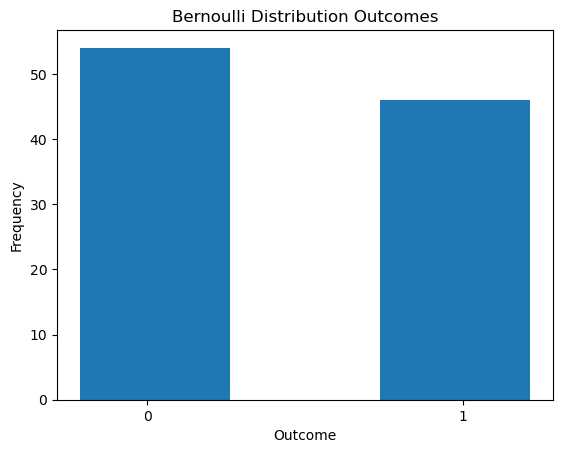

In [59]:
plt.hist(sample1, bins=3)
plt.title('Bernoulli Distribution Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.xticks([0.15, 0.85], ['0', '1'])
plt.show()


#### c) Estimate the value of $\pi$ which is most likely to have generated this set of observations

In [60]:
estimate_p = np.mean(sample1) # estimate p by taking the mean of the sample
print(estimate_p)

0.46


#### d) There is uncertainty around this estimate. In theory, why might such uncertainty arise ? 

#### Answer: 

Sampling error will cause uncertainty when use mean to estimate p value since any particular sample might not perfectly reflect the true p value. Also even with large number of trials, random chance can still lead sample mean to be slightly different from the true p value.

#### e) Represent the uncertainty around this estimate using the empricial posterior distribution evaluated at the MLE. Simulate 1000 values of $\pi$ under this distribution. Plot a histogram of the empirical posterior. 

#### Hint: there are two candidate posterior distributions you can use here -- any one will do...

0.0024840000000000005


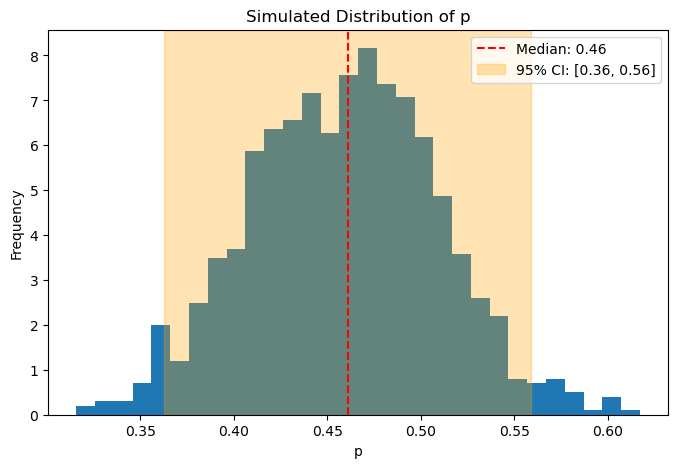

In [87]:
# MLE (Maximum Likelihood Estimation) is the same as mean of the sample for Bernoulli distribution

p_variance = estimate_p * (1 - estimate_p) / n # estimate the variance of the estimate p value, this variance shows how much the estimate p value varies across different samples
print(p_variance)

p_simulation = np.random.normal(loc=estimate_p, scale=np.sqrt(p_variance), size=1000) # simulate 1000 samples of size n from a normal distribution with mean = estimate_p and standard deviation = sqrt(p_variance)

lower_bound = np.percentile(p_simulation, 2.5) # lower bound of the 95% confidence interval
upper_bound = np.percentile(p_simulation, 97.5) # upper bound of the 95% confidence interval

p_median = np.percentile(p_simulation, 50) # median of the distribution

plt.figure(figsize=(8, 5))
plt.hist(p_simulation, bins=30, density=True)
plt.title('Simulated Distribution of p')
plt.xlabel('p')
plt.ylabel('Frequency')
plt.axvline(p_median, color='red', linestyle='--', label=f'Median: {p_median:.2f}')
plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.3, label=f'95% CI: [{lower_bound:.2f}, {upper_bound:.2f}]')

plt.legend()
plt.show()

#### f) For each simulated value of $\pi$, generate a new sample of observations `y`. Plot the histogram of these newly generated samples. If you were to observe a new individual from this population, would you classify them as a right-of-centre voter ? and why ?  

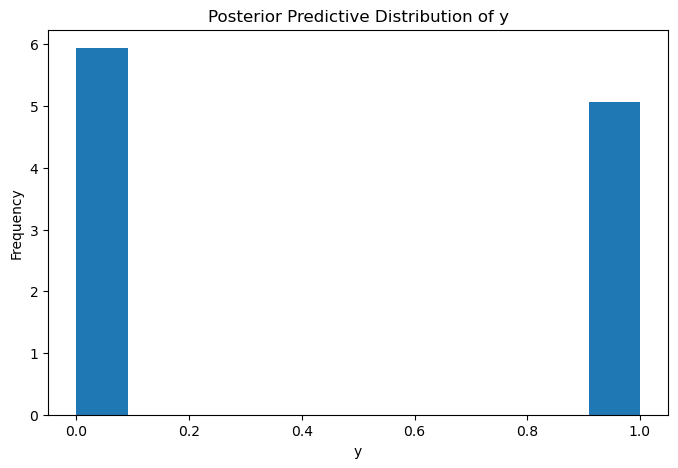

In [117]:
# Here we use the posterior predictive distribution of y to generate new samples for a hypothetical unobserved student

# Generate new values of y corresponding to each value of pi_sims
post_pred_sims = []
for pi in p_simulation:
    y = bernoulli.rvs(pi)
    post_pred_sims.append(y)

plt.figure(figsize=(8, 5))
plt.hist(post_pred_sims, bins='auto', density=True)
plt.title('Posterior Predictive Distribution of y')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.show()

## Exercise II: Logistic Regression, Simulation-Based Inference & Prediction

#### a) Load the ANES 2020 sample, and check the number of respondents. (Hint: it's a `stata` file)

In [ ]:
# Load ANES data
df = ...

# Check dataset size
print(df.shape)

#### b) Subset the dataset to include only people who `intend to vote for president` in the pre-election study (Hint: in the codebook look for variable `V201032`)

In [ ]:
# Focus on voters only 
# Turnout Intention variable: V201032
print(df['V201032'].value_counts())

...

#### c) Define the outcome of interest as 1 if the voter will vote for the Republicans, 0 otherwise. (Hint: in the codebook look for variable `V201033` )

In [ ]:
print(df['V201033'].value_counts())

In [ ]:
Y = ...

#### d) Create a design matrix including age, sex, education or anything else you think would be a good predictor of the vote. # Turn these features into a numeric matrix so we can use them to fit the model. 

#### Note: Remember the `dummy trap`...if you have a categorical variable with `m` possible values, you can only have `m-1` such variables be dummies in your model, due to perfect multi-collinearity...

In [ ]:
# Age: 
age_num = pd.to_numeric(df['V201507x'], errors='coerce')

# College Degree or Higher:
college_edu = df['V201510']...

# Sex:
male_binary = df['V201600']...

# Ethnicity: 
white_binary = df['V201549x']...

# Create design matrix 
X = pd.DataFrame({
    'Age': age_num,
    'College_Degree_or_Higher': college_edu,
    'Sex_Male': male_binary,
    'Ethnicity_White': white_binary
})


# Display the first few rows of the DataFrame
print(X.head())

#### e) Explore the correlation matrix between the covariates and the outcome. Which variables are most linearly related ? Does the direction of the correlation make sense ? Which covariates are most related to the outcome ? 

#### Hint: remember to drop missing values... for both X and Y...

In [ ]:
YX = ...
YX = ...
# Examine the correlation between covariates and outcome (outcome is the first column)
# Can you identify some `perfect multicollinearity' that could hinder the estimation ? 
np.corrcoef(YX.T)

#### f) Fit the logistic regression model using statsmodels. Make sure the estimation procedure has converged.
#### If not, examine the errors and figure out why it's not. Remember to drop the NAs.

In [ ]:
Y = YX[:,0]
X = pd.DataFrame(YX[:,1:], columns=['Age', 'College_Degree', 'Sex_Male', 'Ethnicity_White'])  # Design matrix with column names
X_with_intercept = ...

model = ...

#### g) Get summary of regression output.

In [ ]:
# Get summary results
...
print(summary)

#### h) Simulate 1000 values for for each regression coefficient, from the empirical posterior distribution. Remember this is a Multivariate normal. Use  model.cov_params() to extract the covariance matrix. 

In [ ]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = ...

#### i) Calculate summary statistics from these simulations, along with the probability of the coefficient being > 0 . Plot the histograms for each coefficient. Comment on the statistical significance. What should you do if you wish to compare effect sizes across coefficients ?

In [ ]:
...

#### i) Now let's practice making predictions from this model that we learned. Below is definded the `average american voter`. For this hypothetical person, make a prediction for the probability of voting republican. Ensure to use simulations to gennerate samples of this probability,  and fully account for uncertainty. 

#### Hint: use the `logistic_sigmoid` function to turn simulations of $\mu$ into $\pi$.

In [ ]:
# Calculate the average of the sample for each predictor
average_X = X_with_intercept.mean(axis=0)

# Generate new predicted probabilities for the new observation using the simulated betas
new_predicted_probs = logistic_sigmoid(...)

#### l) Now generate values from the posterior predictive distirbution of the outcome Y (So for this hypothetical average voter, simulate 1000 times who they will vote for). Who does the average american voter turn to in 2020

In [ ]:
# Simulate outcomes for the new observation based on the new predicted probabilities
new_simulated_outcomes = ...

# Plotting both the new predicted probabilities and the simulated outcomes in histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for new predicted probabilities
axes[0].hist(new_predicted_probs, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Predicted Probability')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Plot for simulated outcomes
axes[1].hist(new_simulated_outcomes, bins=2, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Predicted Class')
axes[1].set_xlabel('Simulated Outcome')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()
